## MSMs, OOMs and OPS

This explains how to run OPS simulations for dynamics defined by a Markov state model (MSM).

In [1]:
import openpathsampling as paths
import numpy as np
import openpathsampling.engines.msm as msm
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jan-hendrikprinz/anaconda/envs/ops/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Create a simple MSM, just 4 states. We should put something bigger in here.

In [41]:
p = lambda x: 4.0 * (x ** 8 + 0.5 * np.exp (-40.0 * ((x + 0.5) ** 2)) +
   0.8 * np.exp (-80.0 * (x ** 2)) +
   0.2 * np.exp (-80.0 * ((x - 0.5) ** 2)))

In [52]:
ex = np.array(map(p, np.arange(-0.99, 1.00, 0.02)))

In [49]:
mat = np.array([
    [0.95, 0.05, 0.00, 0.00],
    [0.05, 0.94, 0.01, 0.00],
    [0.00, 0.01, 0.94, 0.05],
    [0.00, 0.00, 0.05, 0.95]
])

Create an engine first. The MSM engine takes a transition matrix. No checks are done so far.

In [3]:
engine = msm.Engine(mat)

create a first snapshot. in MSM these can also be called a `MicroState`

In [4]:
snap = msm.MicroState(
    state=0,
    engine=engine
)
engine.current_snapshot = snap

Generate a first trajectory

In [9]:
r = []
ensA2AB = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB | stateA)),        
    ])
for x in range(100000):
    tt = engine.generate(snap, ensA2AB.can_append)
    r.append(stateB(tt[-1]))

In [10]:
1.0 * sum(r) / len(r)

0.00715

In [11]:
p = 1.0 * sum(r) / len(r)

In [12]:
p + np.sqrt(p * (1.0 - p) / len(r))

0.0074164371877197327

In [13]:
%%time
traj = engine.generate_n_frames(1000)

CPU times: user 47.3 ms, sys: 11.9 ms, total: 59.1 ms
Wall time: 50.5 ms


Define macro states, here just out of single microstates

In [7]:
stateA = msm.Block([0])
stateB = msm.Block([3])

And some interfaces (not needed for TPS)

In [8]:
intA = msm.Block([0,1])
intB = msm.Block([2,3])

Define ensembles for A->B and B->A pathways

In [14]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

And pick the first AB path

In [15]:
# first_AB_list = ensA2B.split(traj)
# firstAB = first_AB_list[0].state

as well as the first BA path

In [16]:
# first_BA_list = ensB2A.split(traj)
# firstBA = first_AB_list[0].state

Now setting up a TPS network consisting of a transition from A2B 

In [17]:
network = paths.TPSNetwork(stateA, stateB)

and a scheme

In [18]:
scheme = paths.OneWayShootingMoveScheme(
    network, 
    selector=paths.UniformSelector(), 
    engine=engine
)

generate the initial conditions, e.g. the sampleset that is used in the beginning. For TPS this is just a single sample that is in the A2B path ensemble. We will scan through all ensembles that are used and pick parts from the initial trajectory that match and add them all to a list. This list is then used to fill the initial sampleset.

In [19]:
useful_trajectory_parts = []
for ens in scheme.find_used_ensembles():
    useful_trajectory_parts.extend(ens.split(traj))

In [20]:
initial_conditions = scheme.initial_conditions_from_trajectories(useful_trajectory_parts)
print scheme.initial_conditions_report(initial_conditions)

No missing ensembles.
No extra ensembles.
No missing ensembles.
No extra ensembles.



We could save for later, but we will do this in memory.

In [21]:
# storage = paths.Storage("msm.nc", "w", use_uuid=False)
# storage.set_caching_mode('analysis')

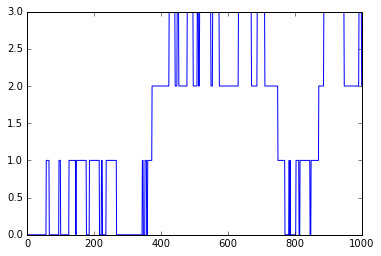

In [22]:
plt.plot(traj.state)

We use a special MSM step sampler that will add all the steps to a list instead of saving these to disk.
You could later save these using `map(storage.steps, steps)`, but we don't want to do that here.

In [23]:
steps=[]

In [24]:
sampler = msm.StepSampling(
    steplist=steps,  
    move_scheme=scheme,
    sample_set=initial_conditions
)

In [25]:
%%time
sampler.run(5000)

Working on Monte Carlo cycle number 5000
Running for 2 minutes 0 seconds -  0.02 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 5000 Monte Carlo cycles.
CPU times: user 1min 49s, sys: 34.4 s, total: 2min 23s
Wall time: 2min


In [26]:
len(steps)

5001

In [27]:
# sum(map(len, storage.trajectories))

In [28]:
# len(storage.trajectories)

In case we want to analyze from storage

In [29]:
# steps = storage.steps

In [30]:
steps[0].active

Get the path lengths

In [31]:
path_lengths = [len(step.active[0].trajectory) for step in steps[1:]]

Maximum: 180 (1800)
Average: 36.30 (363.02)


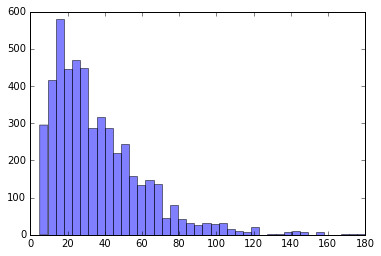

In [32]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);


In [33]:
ooms = np.array([np.dot(np.diag([1 if x == row else 0 for x in range(4)]), mat) for row in range(len(mat))])

Use OOM formalism to compute path probability

In [34]:
oA = ooms[0]
oX = ooms[1] + ooms[2]
oB = ooms[3]
ones = np.ones(4)
pin = np.linalg.eig(mat)[1][0]
pi = pin / sum(pin)

In [35]:
v1 = np.dot(np.dot(pi, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(np.eye(4) - oX))), oB)), ones)
v2 = np.dot(np.dot(pi, oA), ones)

In [36]:
v1/v2

0.0071428571428571305

**TODO: Use analytic expression for pathlength**

And some visualization

In [37]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

In [38]:
history = ops_vis.PathTree(
    steps[:250],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
history.states = {
    'red': stateA,
    'orange': msm.Block([1]),
    'greenyellow': msm.Block([2]),
    'green': stateB
}
history.options.css['scale_x'] = 3
history.options.css['scale_y'] = 5
history.options.movers['ForwardShootMover']['suffix'] = ''
history.options.movers['BackwardShootMover']['suffix'] = ''
history.options.ui['legends'] = []
history.options.css['width'] = '100%'

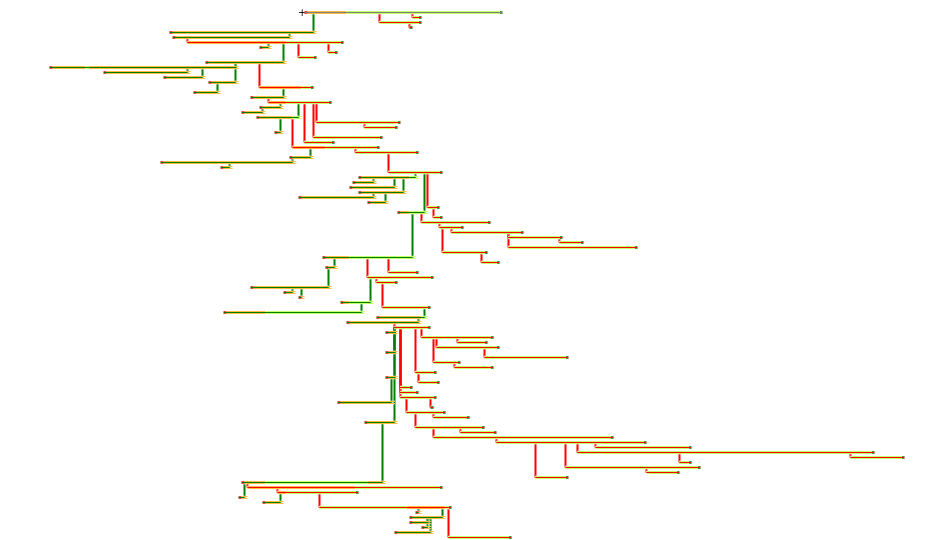

In [39]:
SVG(history.svg())

Use our example 4-well potential

In [98]:
p = lambda x: 4.0 * (x ** 8 + 0.5 * np.exp (-40.0 * ((x + 0.5) ** 2)) +
   0.8 * np.exp (-80.0 * (x ** 2)) +
   0.2 * np.exp (-80.0 * ((x - 0.5) ** 2)))

In [52]:
ex = np.array(map(p, np.arange(-0.99, 1.00, 0.02)))

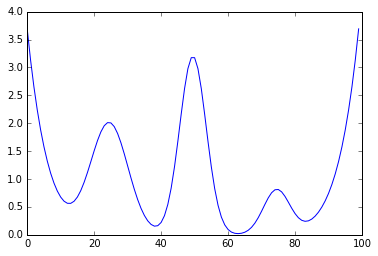

In [100]:
plt.plot(ex)

In [101]:
mat2 = np.zeros( (100, 100))
beta = 1.0
for y in range(100):
    for dx in range(-1,2):
        if y + dx >=0 and y + dx < 100:
            mat2[y, y + dx] = np.exp(- beta * (np.max(ex[y + dx] - ex[y], 0) + 0 * dx*dx) )
            
    mat2[y] *= 1.0 / np.sum(mat2[y])    

In [191]:
mat3 = np.linalg.matrix_power(mat2, 250)

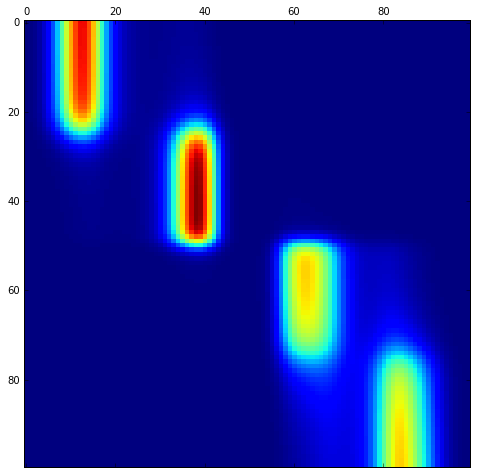

In [603]:
plt.rcParams["figure.figsize"] = 8,8
plt.matshow(mat3);

In [194]:
engine = msm.Engine(mat3)

In [276]:
snap = msm.MicroState(
    state=14,
    engine=engine
)
engine.current_snapshot = snap

In [277]:
%%time
traj = engine.generate_n_frames(1000)

CPU times: user 42.5 ms, sys: 9 ms, total: 51.5 ms
Wall time: 45.2 ms


In [ ]:
# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

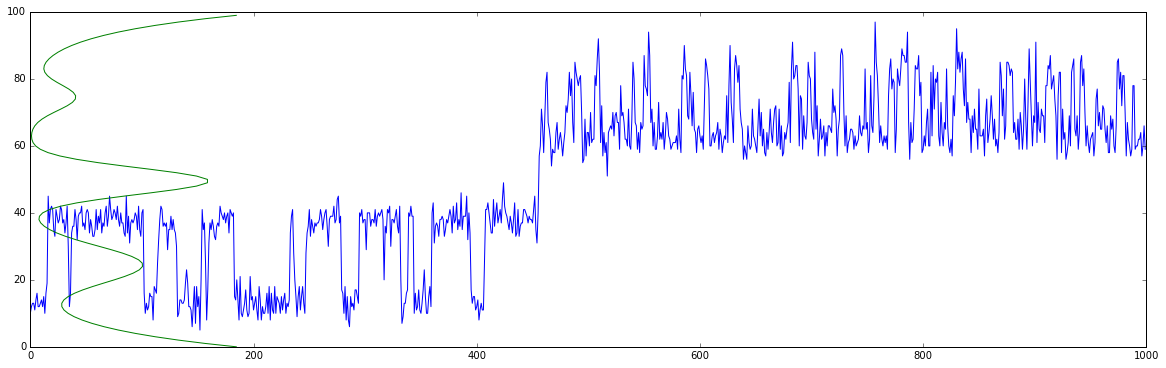

In [618]:
plt.rcParams["figure.figsize"] = 20,6
# row and column sharing
plt.plot(traj.state)
plt.plot(ex * 50, range(0,100))

In [418]:
stateA = msm.Block(range(00,15))
stateB = msm.Block(range(35,40))
stateC = msm.Block(range(60,65))
stateD = msm.Block(range(85,100))

In [419]:
intA = msm.Block(range(15,20))
intB = msm.Block(range(30,45))
intC = msm.Block(range(55,70))
intD = msm.Block(range(80,85))

In [420]:
network = paths.TPSNetwork(stateA, stateD)

In [421]:
ensA2B = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),        
    ])
ensB2A = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateB)),
        paths.AllOutXEnsemble(stateA | stateB),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),        
    ])

In [422]:
scheme = paths.OneWayShootingMoveScheme(
    network, 
    selector=paths.UniformSelector(), 
    engine=engine
)

In [423]:
useful_trajectory_parts = []
for ens in scheme.find_used_ensembles():
    useful_trajectory_parts.extend(ens.split(traj))

In [424]:
useful_trajectory_parts

[Trajectory[83]]

In [425]:
initial_conditions = scheme.initial_conditions_from_trajectories(useful_trajectory_parts)
print scheme.initial_conditions_report(initial_conditions)

No missing ensembles.
No extra ensembles.
No missing ensembles.
No extra ensembles.



In [426]:
steps100=[]

In [427]:
sampler = msm.StepSampling(
    steplist=steps100,  
    move_scheme=scheme,
    sample_set=initial_conditions
)

In [535]:
%%time
sampler.run(2000)

Working on Monte Carlo cycle number 4000
Running for 56 seconds -  0.03 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 4000 Monte Carlo cycles.
CPU times: user 51.7 s, sys: 15.6 s, total: 1min 7s
Wall time: 56.7 s


In [430]:
history100 = ops_vis.PathTree(
    steps100[1:250],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
history100.states = {
    'red': stateA,
    'orange': stateB,
    'green': stateC,
    'blue': stateD
}
history100.options.css['scale_x'] = 3
history100.options.css['scale_y'] = 5
history100.options.movers['ForwardShootMover']['suffix'] = ''
history100.options.movers['BackwardShootMover']['suffix'] = ''
history100.options.ui['legends'] = []
history100.options.css['width'] = '100%' 
history100.options.movers['ForwardShootMover']['css_class'] = ['unknown']
history100.options.movers['BackwardShootMover']['css_class'] = ['unknown']
history100.options.movers['default']['new'] = 'line'
history100.options.movers['default']['label'] = ' '

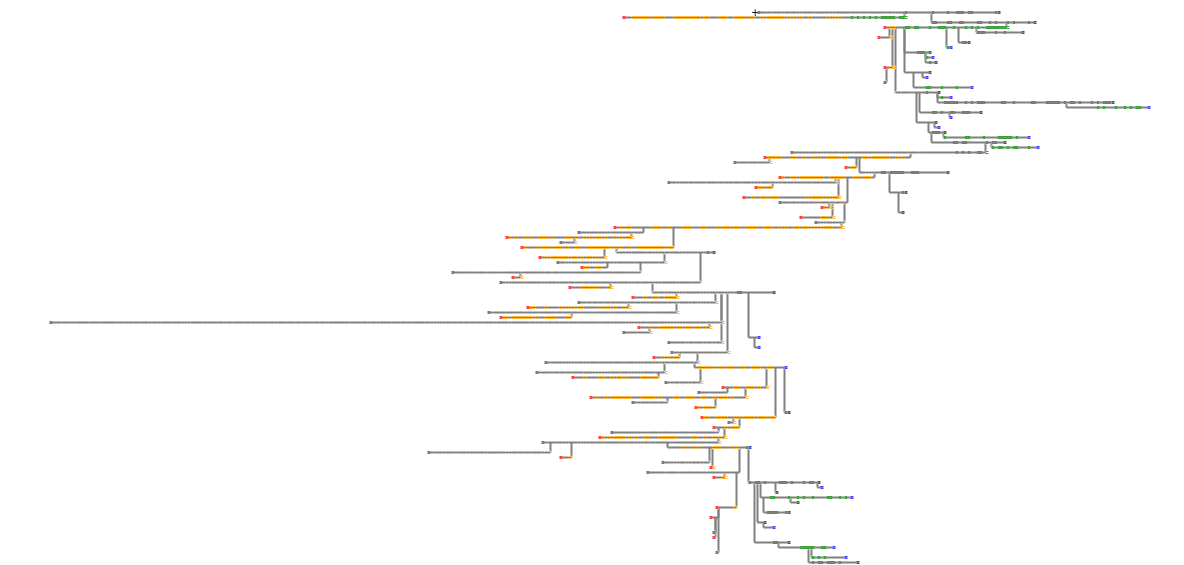

In [431]:
SVG(history100.svg())

In [536]:
path_lengths = [len(step.active[0].trajectory) for step in steps100[1:]]

Maximum: 242 (2420)
Average: 42.08 (420.84)


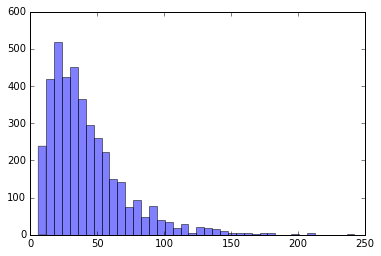

In [537]:
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+"{0:.2f}".format(np.mean(path_lengths)*engine.snapshot_timestep)+")"
plt.hist(path_lengths, bins=40, alpha=0.5);

In [538]:
ooms100 = np.array([np.dot(np.diag([1 if x == row else 0 for x in range(len(mat3))]), mat3) for row in range(len(mat3))])

In [435]:
oA = np.sum(ooms100[list(stateA.states)], axis=0)
oB = np.sum(ooms100[list(stateB.states)], axis=0)
oC = np.sum(ooms100[list(stateC.states)], axis=0)
oD = np.sum(ooms100[list(stateD.states)], axis=0)

In [436]:
oX = mat3 - oA - oD
ones100 = np.ones(len(mat3))
idx = 2
np.linalg.eig(mat3)[0][idx]
pin = np.linalg.eig(np.transpose(mat3))[1][:, idx]

pi = pin / sum(pin)
eye100 = np.eye(100)

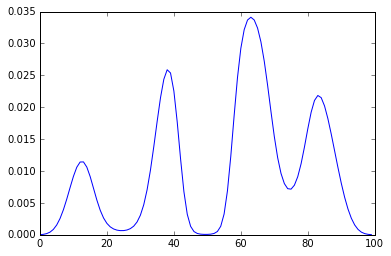

In [437]:
plt.plot(pi)

In [543]:
v1 = np.dot(np.dot(pi, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(eye100 - oX))), oD)), ones)
v2 = np.dot(np.dot(pi, oA), ones)
v1 / v2

(0.013006018288763145+0j)

In [573]:
xx = np.array([1 if x == 14 else 0 for x in range(len(mat3))])

In [574]:
v1 = np.dot(np.dot(xx, np.dot(np.dot(oA, np.dot(oX, np.linalg.inv(eye100 - oX))), oD)), ones)
v2 = np.dot(np.dot(xx, oA), ones)
v1 / v2

0.014484765717513209

In [586]:
r = []
ensA2AD = paths.SequentialEnsemble([
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateA)),
        paths.AllOutXEnsemble(stateA | stateD),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(stateD | stateA)),        
    ])
for x in range(100000):
    tt = engine.generate(snap, ensA2AD.can_append)
    r.append(stateD(tt[-1]))

In [590]:
1.0 * sum(r) / len(r)

0.01428

In [591]:
np.sqrt(0.014 / len(r))

0.00037416573867739413

In [ ]:
probability